## Predicting energy usage

### Load and examine the data

In [25]:
data_bucket = 'forimd-east-1' # change the name odf your bucket
subfolder = 'forecast'

In [26]:
%matplotlib inline

import sys
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import pandas as pd                               
import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# correspond to Version 2.x of the SageMaker Python SDK
# Check the latest version of SageMaker
if int(sagemaker.__version__.split('.')[0]) == 2:
    print("Version is good")
else:
    !{sys.executable} -m pip install --upgrade sagemaker
    print("Installing latest SageMaker Version. Please restart the kernel")
    
role = sagemaker.get_execution_role()
s3 = s3fs.S3FileSystem(anon=False)

Version is good


In [27]:
s3_data_path = f"s3://{data_bucket}/{subfolder}/data"
s3_output_path = f"s3://{data_bucket}/{subfolder}/output"
# df = pd.read_csv(f's3://{data_bucket}/{subfolder}/meter_data.csv', index_col=0)
df = pd.read_csv('meter_data.csv', index_col=0)
df.head()

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_47,Site_46,Site_48
2017-11-01 00:00:00,13.30,13.3,11.68,13.02,0.0,102.9,11.4,21.8,9.7,11.9,...,22.20,0.0,0.0,0,23.30,36.74,48.48,68.70,32.13,19.39
2017-11-01 00:30:00,11.75,11.9,12.63,13.36,0.0,122.1,11.3,17.7,9.0,12.4,...,21.68,0.0,0.0,0,22.14,36.44,50.18,69.09,29.02,19.54
2017-11-01 01:00:00,12.58,11.4,11.86,13.04,0.0,110.3,10.9,17.5,9.1,12.0,...,21.56,0.0,0.0,0,21.88,35.93,49.44,67.52,26.65,20.10
2017-11-01 01:30:00,12.50,10.8,11.53,11.83,0.0,83.6,11.2,16.5,12.4,11.5,...,21.28,0.0,0.0,0,22.69,45.25,49.57,68.48,25.28,19.46
2017-11-01 02:00:00,12.98,12.0,11.57,12.25,0.0,91.4,10.9,16.3,12.4,11.3,...,40.48,0.0,0.0,0,22.75,62.94,48.58,75.30,23.65,19.18


In [28]:
print(f'Number of rows in dataset: {df.shape[0]}')
print(f'Number of columns in dataset: {df.shape[1]}')

Number of rows in dataset: 19632
Number of columns in dataset: 48


### Get the data in the right shape

In [29]:
df.index = pd.to_datetime(df.index)
daily_df = df.resample('D').sum()
daily_df.head()

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_47,Site_46,Site_48
2017-11-01,1184.23,1039.1,985.95,1205.07,0.0,6684.4,1192.1,1256.1,982.6,1001.4,...,1548.92,0.0,0.0,0,1573.23,2871.58,2303.38,2977.41,2672.10,2298.95
2017-11-02,1210.90,1084.7,1013.91,1252.44,0.0,6894.3,1238.6,1249.4,1023.6,997.4,...,1539.52,0.0,0.0,0,1537.35,2890.60,2290.59,2988.84,2658.95,2112.39
2017-11-03,1247.60,1004.2,963.95,1222.40,0.0,6841.0,1174.3,1210.3,990.3,1009.3,...,1487.40,0.0,0.0,0,1615.69,2737.92,2289.75,2898.06,2642.38,2475.31
2017-11-04,1246.92,936.2,877.97,1157.45,0.0,6079.1,1041.2,1086.7,879.3,854.7,...,325.96,0.0,0.0,0,888.55,1726.20,2127.39,2617.02,1429.63,564.29
2017-11-05,1189.20,830.8,798.97,975.69,0.0,5221.5,929.4,1068.0,767.7,785.8,...,318.24,0.0,0.0,0,867.91,1849.85,2124.23,2320.60,726.15,554.00


In [30]:
print(daily_df.shape)
print(f'Time series starts at {daily_df.index[0]} \
and ends at {daily_df.index[-1]}')

(409, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2018-12-14 00:00:00


In [31]:
daily_df = daily_df.fillna(daily_df.shift(7))
daily_df

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_47,Site_46,Site_48
2017-11-01,1184.23,1039.1,985.95,1205.07,0.0,6684.4,1192.1,1256.1,982.6,1001.4,...,1548.92,0.0,0.0,0,1573.23,2871.58,2303.38,2977.41,2672.10,2298.95
2017-11-02,1210.90,1084.7,1013.91,1252.44,0.0,6894.3,1238.6,1249.4,1023.6,997.4,...,1539.52,0.0,0.0,0,1537.35,2890.60,2290.59,2988.84,2658.95,2112.39
2017-11-03,1247.60,1004.2,963.95,1222.40,0.0,6841.0,1174.3,1210.3,990.3,1009.3,...,1487.40,0.0,0.0,0,1615.69,2737.92,2289.75,2898.06,2642.38,2475.31
2017-11-04,1246.92,936.2,877.97,1157.45,0.0,6079.1,1041.2,1086.7,879.3,854.7,...,325.96,0.0,0.0,0,888.55,1726.20,2127.39,2617.02,1429.63,564.29
2017-11-05,1189.20,830.8,798.97,975.69,0.0,5221.5,929.4,1068.0,767.7,785.8,...,318.24,0.0,0.0,0,867.91,1849.85,2124.23,2320.60,726.15,554.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-10,1212.53,1070.1,1022.02,1239.53,1137.5,7216.9,574.0,677.3,1147.9,543.6,...,856.86,82760.0,71598.8,189,1865.03,3046.84,2497.72,2277.67,2724.62,852.67
2018-12-11,1318.45,1169.4,1119.27,1283.12,1254.8,8242.2,588.8,799.3,1215.9,624.4,...,957.00,81950.0,61727.4,298,1799.40,3005.03,2529.41,2247.49,2978.10,946.53
2018-12-12,1401.15,1232.6,1148.00,1378.76,1323.0,8792.0,730.3,959.6,1259.0,774.0,...,921.79,81380.0,72383.1,260,1713.26,2906.75,2435.32,0.00,3342.16,847.77
2018-12-13,1217.92,1058.8,1030.33,1258.77,1022.0,7400.2,668.1,720.8,1018.5,620.3,...,994.97,81770.0,67201.9,278,1788.17,3085.25,2617.42,2530.96,3143.55,997.05


Number of time series: 48


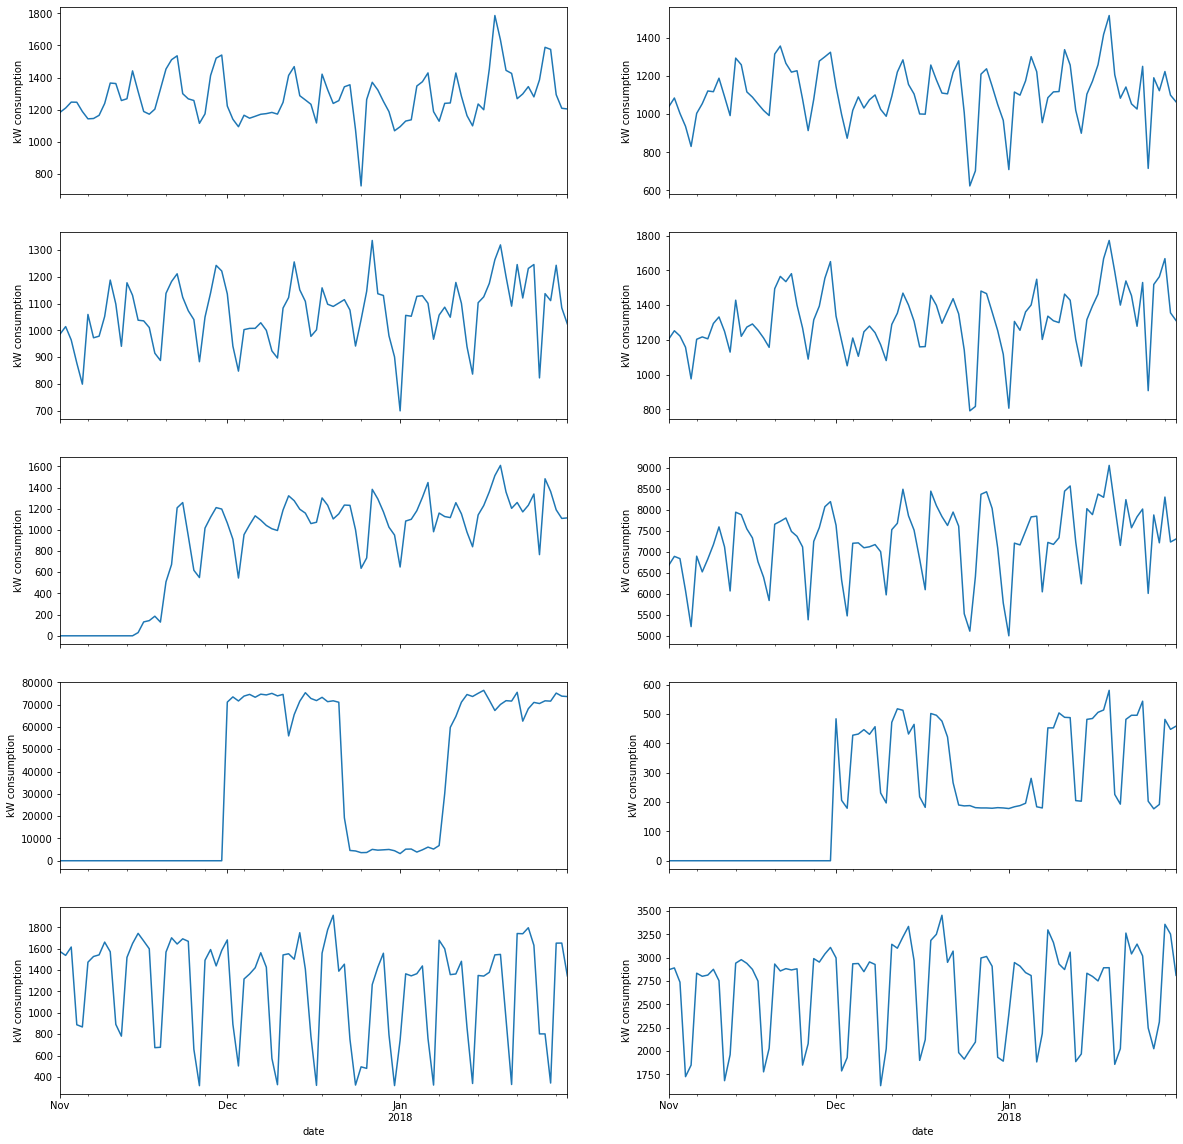

In [32]:
print('Number of time series:',daily_df.shape[1])
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
indices = [0,1,2,3,4,5,40,41,42,43]
for i in indices:
    plot_num = indices.index(i)
    daily_df[daily_df.columns[i]].loc["2017-11-01":"2018-01-31"].plot(ax=axx[plot_num])
    axx[plot_num].set_xlabel("date")    
    axx[plot_num].set_ylabel("kW consumption")

### Create Train and Test Datasets

In [33]:
daily_power_consumption_per_site = []
for column in daily_df.columns:
    site_consumption = np.trim_zeros(daily_df[column], trim='f')
    site_consumption = site_consumption.fillna(0)
    daily_power_consumption_per_site.append(site_consumption)
    
print(f'Time series covers {len(daily_power_consumption_per_site[0])} days.')
print(f'Time series starts at {daily_power_consumption_per_site[0].index[0]}')
print(f'Time series ends at {daily_power_consumption_per_site[0].index[-1]}') 

Time series covers 409 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2018-12-14 00:00:00


In [34]:
freq = 'D'
prediction_length = 30

from datetime import timedelta

start_date = pd.Timestamp("2017-11-01 00:00:00", freq=freq)
end_training = start_date + datetime.timedelta(364)
end_testing = end_training + datetime.timedelta(prediction_length)

print(f'End training: {end_training}, End testing: {end_testing}')

End training: 2018-10-31 00:00:00, End testing: 2018-11-30 00:00:00


In [35]:
training_data = [
    {
        "start": str(start_date),
        "target": ts[start_date:end_training].tolist()
    }
    for ts in daily_power_consumption_per_site
]

test_data = [
    {
        "start": str(start_date),
        "target": ts[start_date:end_testing].tolist()
    }
    for ts in daily_power_consumption_per_site
]

In [36]:
def write_dicts_to_s3(path, data):
    with s3.open(path, 'wb') as f:
        for d in data:
            f.write(json.dumps(d).encode("utf-8"))
            f.write("\n".encode('utf-8'))
            
write_dicts_to_s3(f'{s3_data_path}/train/train.json', training_data)
write_dicts_to_s3(f'{s3_data_path}/test/test.json', test_data)

### Train Model

In [37]:
s3_output_path = f's3://{data_bucket}/{subfolder}/output'
sess = sagemaker.Session()
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", sess.boto_region_name, "latest")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [38]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sess,
    image_uri=image_name,
    role=role,
    instance_count=1,
    instance_type='ml.c5.2xlarge', # $0.476 per hour as of Jan 2019.
    base_job_name='ch6-energy-usage',
    output_path=s3_output_path
)

In [39]:
estimator.set_hyperparameters(
    time_freq=freq,
    epochs="400",
    early_stopping_patience="40",
    mini_batch_size="64",
    learning_rate="5E-4",
    context_length="90",
    prediction_length=str(prediction_length)
)

In [40]:
%%time
data_channels = {
    "train": "{}/train/".format(s3_data_path),
    "test": "{}/test/".format(s3_data_path)
}
estimator.fit(inputs=data_channels, wait=True)

2022-06-18 15:48:42 Starting - Starting the training job...
2022-06-18 15:48:58 Starting - Preparing the instances for trainingProfilerReport-1655567322: InProgress
......
2022-06-18 15:50:08 Downloading - Downloading input data
2022-06-18 15:50:08 Training - Downloading the training image......
2022-06-18 15:51:09 Training - Training image download completed. Training in progress..Arguments: train
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[06/18/2022 15:51:13 INFO 139697944840000] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stoppin

### Host the model

In [41]:
endpoint_name = 'energy-usage'

try:
    sess.delete_endpoint(
        sagemaker.predictor.Predictor(endpoint=endpoint_name).endpoint, delete_endpoint_config=True)
    print('Warning: Existing endpoint and configuration deleted to make way for your new endpoint.')
    from time import sleep
    sleep(30)
except:
    pass

In [42]:
from sagemaker.serializers import IdentitySerializer

In [43]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, 
                         #serializer=JSONSerializer(),
                         serializer=IdentitySerializer(content_type="application/json"),
                         **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        """Requests the prediction of for the time series listed in `ts`, each with the (optional)
        corresponding category listed in `cat`.
        
        ts -- `pandas.Series` object, the time series to predict
        cat -- integer, the group associated to the time series (default: None)
        num_samples -- integer, number of samples to compute at prediction time (default: 100)
        return_samples -- boolean indicating whether to include samples in the response (default: False)
        quantiles -- list of strings specifying the quantiles to compute (default: ["0.1", "0.5", "0.9"])
        
        Return value: list of `pandas.DataFrame` objects, each containing the predictions
        """
        prediction_time = ts.index[-1] + ts.index.freq
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        # we only sent one time series so we only receive one in return
        # however, if possible one will pass multiple time series as predictions will then be faster
        predictions = json.loads(response.decode('utf-8'))['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    """Given a pandas.Series object, returns a dictionary encoding the time series.

    ts -- a pands.Series object with the target time series
    cat -- an integer indicating the time series category

    Return value: a dictionary
    """
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

In [44]:
%%time

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor,
    endpoint_name=endpoint_name)

------!CPU times: user 110 ms, sys: 10.1 ms, total: 120 ms
Wall time: 3min 1s


In [45]:
predictor.predict(ts=daily_power_consumption_per_site[0][start_date+datetime.timedelta(30):end_training],quantiles=[0.1, 0.5, 0.9]).head()

,0.1,0.5,0.9
2018-11-01,1109.124023,1203.665405,1298.124268
2018-11-02,1062.684082,1169.884888,1256.867798
2018-11-03,1011.255554,1115.011719,1252.211914
2018-11-04,976.507263,1078.465332,1181.248169
2018-11-05,1054.501953,1179.982422,1280.928589


In [46]:
def plot(
    predictor, 
    target_ts,
    end_training=end_training, 
    plot_weeks=12,
    confidence=80
):
    print(f"Calling served model to generate predictions starting from {end_training} to {end_training+datetime.timedelta(prediction_length)}")
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
        
    plot_history = plot_weeks * 7

    fig = plt.figure(figsize=(20, 3))
    ax = plt.subplot(1,1,1)
    
    prediction = predictor.predict(ts=target_ts[:end_training], quantiles=[low_quantile, 0.5, up_quantile])
                
    target_section = target_ts[end_training-datetime.timedelta(plot_history):end_training+datetime.timedelta(prediction_length)]
    target_section.plot(color="black", label='Actual')
    
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )
#     prediction["0.5"].plot(color="b", label='P50')
    ax.legend(loc=2)    
    
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

Calling served model to generate predictions starting from 2018-10-31 00:00:00 to 2018-11-30 00:00:00


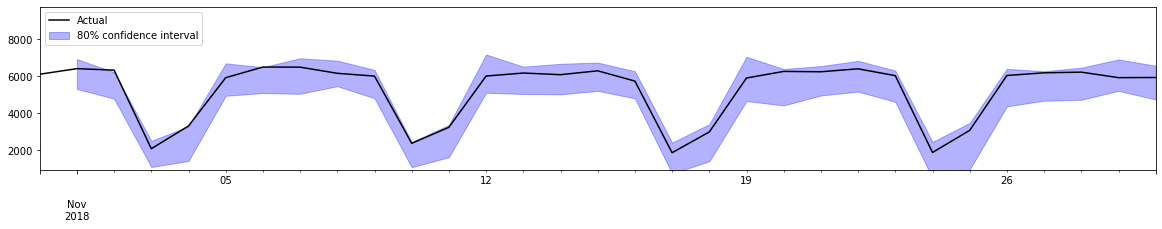

In [47]:
site_id = 33
plot_weeks = 0
confidence = 80
plot(
        predictor,
        target_ts=daily_power_consumption_per_site[site_id][start_date+datetime.timedelta(30):],
        plot_weeks=plot_weeks,
        confidence=confidence
    )

### Calculate some objective statistics recarding accuracy of our model

In [48]:
# Gather 30 day predictions for all timeseries
predictions= []
for i, ts in enumerate(daily_power_consumption_per_site):

    # call the end point to get the 30 day prediction
    predictions.append(predictor.predict(ts=ts[start_date+datetime.timedelta(30):end_training])['0.5'].sum())

usages = [ts[end_training+datetime.timedelta(1):end_training+datetime.timedelta(30)].sum() for ts in daily_power_consumption_per_site]

for p,u in zip(predictions,usages):
    print(f'Predicted {p} kwh but usage was {u} kwh,')

Predicted 33480.0631713867 kwh but usage was 35992.200000000004 kwh,
Predicted 27771.346008300592 kwh but usage was 31043.100000000002 kwh,
Predicted 25586.122863769502 kwh but usage was 29255.000000000004 kwh,
Predicted 28291.160522461 kwh but usage was 34938.78999999999 kwh,
Predicted 27415.7078247071 kwh but usage was 30740.199999999997 kwh,
Predicted 191052.5830078127 kwh but usage was 205150.09999999998 kwh,
Predicted 16899.0675048826 kwh but usage was 17890.7 kwh,
Predicted 18630.1273193358 kwh but usage was 19438.399999999998 kwh,
Predicted 27089.821655273096 kwh but usage was 30865.399999999998 kwh,
Predicted 15481.267089843901 kwh but usage was 16576.800000000003 kwh,
Predicted 28917.1926269531 kwh but usage was 32731.429999999997 kwh,
Predicted 31491.615295410204 kwh but usage was 34270.9 kwh,
Predicted 17543.421630859302 kwh but usage was 20208.000000000007 kwh,
Predicted 28155.9921264648 kwh but usage was 31776.2 kwh,
Predicted 31032.3611450195 kwh but usage was 34083.0 kwh

In [49]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [50]:
print(f'MAPE: {round(mape(usages, predictions),1)}%')

MAPE: 7.2%


### Remove the Endpoint

In [ ]:
sagemaker.Session().delete_endpoint(endpoint_name)